In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from collections import Counter
#stopwords = set(STOPWORDS)
import itertools
import nltk
# nltk.download()
# nltk.download('stopwords')
# nltk.download("punkt")
# nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from nltk import ne_chunk
from nltk.util import ngrams
from nltk.book import *

import plotly
import plotly.express as px

import re
import string



#read the files
train = pd.read_csv("/Users/legfot/Documents/content/data/train.csv", encoding = 'ISO-8859-1')
test = pd.read_csv("/Users/legfot/Documents/content/data/test.csv", encoding = 'ISO-8859-1')
test_y = pd.read_csv("/Users/legfot/Documents/content/data/test_labels.csv", encoding = 'ISO-8859-1')


stop = stopwords.words('english')

train['preprocess'] = train.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1) #removes new line character
test['preprocess'] = test.apply(lambda row: row['comment_text'].replace("\n"," "), axis=1)

#removes urls
train['preprocess']=train.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('http://\S+|https://\S+', 'urls',row['preprocess']).lower(), axis=1)

#remove all non-alphanumeric values(Except single quotes)
train['preprocess']=train.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('[^A-Za-z\' ]+', '',row['preprocess']).lower(), axis=1)

#remove stopwords as they occupy major chunk of the vocabulary
train['preprocess'] = train['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test['preprocess'] = test['preprocess'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#removes all additional spaces
train['preprocess']=train.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)
test['preprocess']=test.apply(lambda row: re.sub('  +', ' ',row['preprocess']).strip(), axis=1)

train["preprocess1"] = train.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)
test["preprocess1"] = test.apply(lambda x: x["comment_text"] if len(x["preprocess"])==0 else x['preprocess'], axis=1)
traindf=train[['preprocess1','toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testdf=test[['id','preprocess1']]

from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Input
from tensorflow.keras.callbacks import ModelCheckpoint
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

traind=traindf["preprocess1"]
train_label=traindf[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]
testd=testdf["preprocess1"]

#prepare tokenizer
tokenizer = Tokenizer(num_words = 30000) #only 30000 words i am considering here
tokenizer.fit_on_texts(traind)

#convert each text into array of integers with help of tokenizer.
train_final = tokenizer.texts_to_sequences(traind)
test_final = tokenizer.texts_to_sequences(testd)
#Now lets pad the sentences. 
#From the above histogram it is evident that most of sentences falling in range 1-200 lengths. 
#max length=200 is kept 
#We will trim any sentence above that length and we will pad zeros for all the sentence below 200
traind=pad_sequences(train_final, maxlen=200)
testd=pad_sequences(test_final, maxlen=200)

import tensorflow as tf
MAX_FEATURES = 30000
MAX_SENTENCE_LENGTH = 200


def LSTM_model(lstm_units, dropout_rate):
    model = Sequential([
        tf.keras.layers.InputLayer(input_shape=(MAX_SENTENCE_LENGTH,)),
        tf.keras.layers.Embedding(input_dim=MAX_FEATURES, output_dim=int(MAX_FEATURES ** 0.25)),
        tf.keras.layers.LSTM(units=lstm_units),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(6, activation=tf.nn.sigmoid)
    ])
    model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    return model

# define some hyper parameters
batch_size = 32
epochs = 5
lstm_units = 30 #Dimensions of the output layer
dropout_rate = 0.5

# define the model
LSTM_model = LSTM_model(lstm_units, dropout_rate)
print(LSTM_model.summary())

# define some callbacks
checkpoint_cb = ModelCheckpoint(filepath='model_toxic/cp.ckpt',
                                save_weights_only=True,
                                mode='min',
                                verbose=1,
                                save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='model_toxic',
                             histogram_freq=1,
                             write_grads=True)

# start train and evaluate
LSTM_model_history = LSTM_model.fit(
                x=traind,
                y=train_label,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[checkpoint_cb, tensorboard_cb],
            )

loss = LSTM_model_history.history['loss']



*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.
text1: Moby Dick by Herman Melville 1851
text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis
text4: Inaugural Address Corpus
text5: Chat Corpus
text6: Monty Python and the Holy Grail
text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


2023-04-23 00:33:17.932612: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-23 00:33:17.933317: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 13)           390000    
                                                                 
 lstm (LSTM)                 (None, 30)                5280      
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 dense (Dense)               (None, 6)                 186       
                                                                 
Total params: 395,466
Trainable params: 395,466
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5


2023-04-23 00:33:18.388732: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-23 00:33:19.077174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 00:33:19.317184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 00:33:20.248163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3990/3990 [==============================] - ETA: 0s - loss: 0.1449 - accuracy: 0.9066

2023-04-23 00:37:56.662141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 00:37:56.722261: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.13465, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 303s 75ms/step - loss: 0.1449 - accuracy: 0.9066 - val_loss: 0.1346 - val_accuracy: 0.9941
Epoch 2/5
3990/3990 [==============================] - ETA: 0s - loss: 0.1350 - accuracy: 0.9931
Epoch 00002: val_loss improved from 0.13465 to 0.13278, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 315s 79ms/step - loss: 0.1350 - accuracy: 0.9931 - val_loss: 0.1328 - val_accuracy: 0.9941
Epoch 3/5
3990/3990 [==============================] - ETA: 0s - loss: 0.1319 - accuracy: 0.9932
Epoch 00003: val_loss improved from 0.13278 to 0.12851, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 318s 80ms/step - loss: 0.1319 - accuracy: 0.9932 - val_loss: 0.1285 - val_accuracy: 0.9941
Epoch 4/5
3990/3990 [==============================] - ETA: 0s - loss: 0.1173 - accuracy: 0.9933
Epoch 00004: val_loss improv

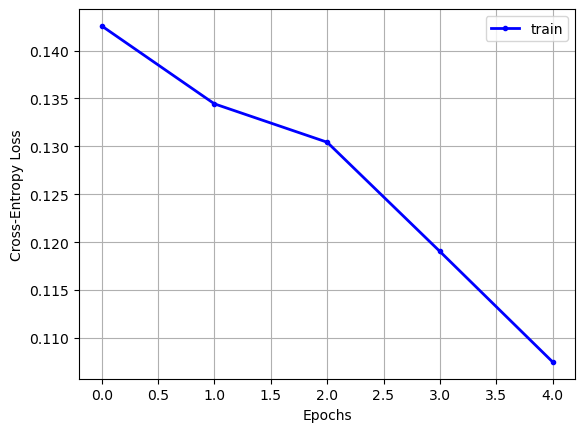

In [14]:
# x_len = np.arange(len(loss))
# # plt.plot(x_len, vloss, marker='.', lw=2.0, c='red', label='val')
# plt.plot(x_len, loss, marker='.', lw=2.0, c='blue', label='train')
plt.figure()
plt.plot(loss, marker='.', lw=2.0, c='blue', label='train')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.grid()
plt.show()

In [2]:
train.rename(columns={'toxic':'toxicity'})


,id,comment_text,toxicity,severe_toxic,obscene,threat,insult,identity_hate,preprocess,preprocess1
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...,explanation edits made username hardcore metal...
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,d'aww matches background colour i'm seemingly ...,d'aww matches background colour i'm seemingly ...
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man i'm really trying edit war guy constan...,hey man i'm really trying edit war guy constan...
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,can't make real suggestions improvement wonder...,can't make real suggestions improvement wonder...
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page that's,sir hero chance remember page that's
...,...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,second time asking view completely contradicts...,second time asking view completely contradicts...
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,ashamed horrible thing put talk page,ashamed horrible thing put talk page
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,spitzer umm theres actual article prostitution...,spitzer umm theres actual article prostitution...
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,looks like actually put speedy first version d...,looks like actually put speedy first version d...


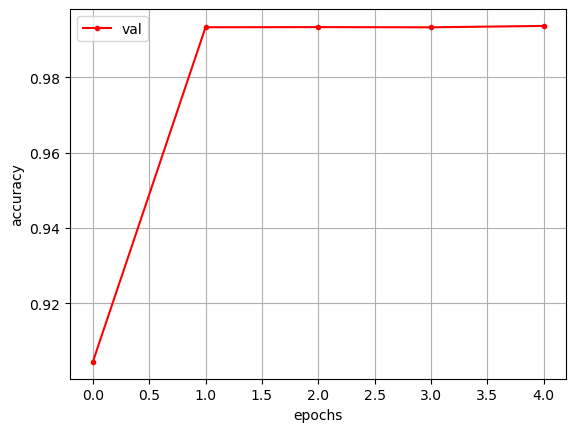

In [5]:
plt.figure()
plt.plot(LSTM_model_history.history['accuracy'], marker='.', c='red', label='val')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.show()

In [3]:
LSTM_result = testdf[['id']]
LSTM_preds = LSTM_model.predict(testd)
LSTM_result[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = LSTM_preds
# LSTM_result.to_csv("result_LSTM.csv", index = False)

2023-04-23 01:37:52.361931: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 01:37:52.432138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


## Evaluate LSTM Model

In [91]:
LSTM_result = pd.read_csv('/Users/legfot/Documents/NLP实训项目/恶意评论/result_LSTM.csv', encoding = 'ISO-8859-1')
#change posibility into labels
col = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
thresh = 0.5

for i in range(len(col)):
    LSTM_result[col[i]] = LSTM_result[col[i]].apply(lambda x:1 if x > thresh  else 0)

#pre_L
nid_LSTM_result = LSTM_result.drop('id',axis=1)
pre_L = nid_LSTM_result.values
pre_L = pre_L[test_y['toxic'] != -1]
sc_LSTM_re = nid_LSTM_result[test_y['toxic'] != -1]

#actual label for scoring
test_y_score = test_y[test_y['toxic'] != -1]
test_y_score = test_y_score.drop('id',axis=1)
test_label_L = test_y_score.values

[[[57474   414]
  [ 4759  1331]]

 [[63486   125]
  [  310    57]]

 [[59924   363]
  [ 2839   852]]

 [[63767     0]
  [  211     0]]

 [[60195   356]
  [ 2710   717]]

 [[63266     0]
  [  712     0]]]


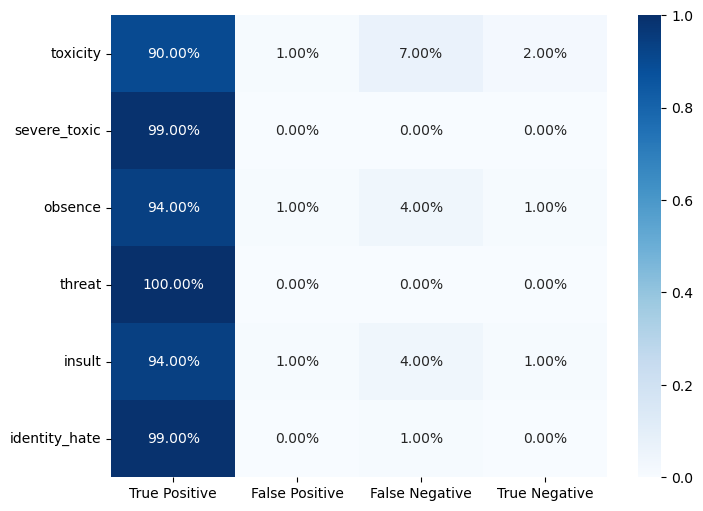

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix


# 生成随机的混淆矩阵
mcm_LSTM = multilabel_confusion_matrix(test_label_L, pre_L) # target在前，pred在后
print(mcm_LSTM)

# 将3维数组展开为2维数组
flat_matrix = np.reshape(mcm_LSTM, (mcm_LSTM.shape[0], -1))
conf_matrix_pct = np.around(flat_matrix / np.sum(flat_matrix, axis=1, keepdims=True) , decimals=2)


# 绘制热力图
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix_pct, annot=True, fmt = '.2%',cmap='Blues')


# 设置坐标轴标签
# ax.set_xticks([0.5, 1.5, 2, 2,5])
# 设置行标签
ax.set_yticklabels(['toxicity', 'severe_toxic', 'obsence', 'threat','insult', 'identity_hate'], rotation=0)

# 设置列标签
ax.set_xticklabels(['True Positive', 'False Positive', 'False Negative', 'True Negative'], fontsize=10)
# ax.set_xticklabels(['True Negative', 'True Positive','False Negative','False Positive'])
# ax.set_yticklabels(['toxicity', 'severe_toxic', 'threat', 'obsence', 'insult', 'identity_hate'])

# 显示图形
plt.show()


In [48]:
from sklearn.metrics import classification_report

class_names = ['toxicity', 'severe_toxic', 'obsence', 'threat','insult', 'identity_hate']


# 按照类别生成分类报告
for i in range(len(class_names)):
    target_names = ['non-' + class_names[i], class_names[i]]
    report = classification_report(test_label_L[:,i], pre_L[:,i])
    print(f'Classification Report for {class_names[i]}:\n{report}\n')



Classification Report for toxicity:
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     57888
           1       0.76      0.22      0.34      6090

    accuracy                           0.92     63978
   macro avg       0.84      0.61      0.65     63978
weighted avg       0.91      0.92      0.90     63978


Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63611
           1       0.31      0.16      0.21       367

    accuracy                           0.99     63978
   macro avg       0.65      0.58      0.60     63978
weighted avg       0.99      0.99      0.99     63978


Classification Report for obsence:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97     60287
           1       0.70      0.23      0.35      3691

    accuracy                           0.95     63978
   macro avg   

/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [9]:
test_y_score = test_y_score.rename(columns={'toxic':'toxicity'})
sc_LSTM_re = sc_LSTM_re.rename(columns={'toxic':'toxicity'})
sc_LSTM_re
# sc_GRU_re = sc_GRU_re.rename(columns={'toxic':'toxicity'})

,toxicity,severe_toxic,obscene,threat,insult,identity_hate
5,0,0,0,0,0,0
7,0,0,0,0,0,0
11,0,0,0,0,0,0
13,0,0,0,0,0,0
14,0,0,0,0,0,0
...,...,...,...,...,...,...
153150,0,0,0,0,0,0
153151,0,0,0,0,0,0
153154,0,0,0,0,0,0
153155,1,0,1,0,0,0


## Error Analysis 

In [127]:
# pd.set_option('display.max_colwidth', 1000)
print(GRU_result[GRU_result['id'] == '025d45d14a2e030a'])

print(test[test['id'] == '025d45d14a2e030a'])

                    id  toxic  severe_toxic  obscene  threat  insult  \
1407  025d45d14a2e030a      1             0        1       0       1   

      identity_hate  
1407              0  
                    id  \
1407  025d45d14a2e030a   

                                                                                  comment_text  \
1407  FUCK YOU YOU LIKE ANGELIQUE CARRINGTON AND TAMARA HARRINGTON??????FUCK YOU ASSHOLE!!!!!!   

                                                        preprocess  \
1407  fuck like angelique carrington tamara harringtonfuck asshole   

                                                       preprocess1  
1407  fuck like angelique carrington tamara harringtonfuck asshole  


In [132]:
test_y[test_y['identity_hate'] ==1]

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
48,0013fed3aeae76b7,1,0,1,0,1,1
349,00950f0fae33869f,1,0,1,0,1,1
395,00a7a3ddf7f5878b,1,0,1,0,1,1
475,00c8d5a33c6a7b2f,1,0,1,0,1,1
782,014a9dafac3a92a4,1,0,0,0,0,1
...,...,...,...,...,...,...,...
151745,fd8cd8f3bec6bfeb,1,0,1,0,1,1
151981,fdf9032ae1e3368d,1,0,1,0,1,1
152324,fe9315bad284186b,1,1,1,0,1,1
152327,fe93a5366ca20f0d,1,1,1,1,1,1


In [117]:
print(train['id'][train['preprocess1'].str.contains('islam')] )

206       0082b5a7b4a67da2
511       0155c0f1599a2a41
666       01cec91ecf91d6ff
696       01e1fe72324cfa35
864       025c5d5f1bf91d84
                ...       
158530    ef648c74930151de
158781    f399d47dceb46e3d
158833    f48c850e2b731a57
159421    fd64f6e1adc0b902
159475    fe93b5e609f5cfdd
Name: id, Length: 787, dtype: object


## train the GRU Model

In [36]:
import tensorflow as tf
import tensorflow.keras as keras
def GRU_model(lstm_units, dropout_rate):
    GRU_model = Sequential([
        keras.layers.InputLayer(input_shape=(MAX_SENTENCE_LENGTH,)),
        keras.layers.Embedding(input_dim=MAX_FEATURES, output_dim=int(MAX_FEATURES ** 0.25)),
        keras.layers.GRU(units=lstm_units),
        keras.layers.Dropout(dropout_rate),
        keras.layers.Dense(6, activation=tf.nn.sigmoid)
    ])
    GRU_model.compile(
        loss=tf.keras.losses.binary_crossentropy,
        metrics=['accuracy']
    )
    return GRU_model

# define some hyper parameters
batch_size = 32
epochs = 2
lstm_units = 50
dropout_rate = 0.5

# define the model
GRU_model = GRU_model(lstm_units, dropout_rate)
print(GRU_model.summary())

# define some callbacks
checkpoint_cb = ModelCheckpoint(filepath='model_toxic/cp.ckpt',
                                save_weights_only=True,
                                mode='min',
                                verbose=1,
                                save_best_only=True)
tensorboard_cb = TensorBoard(log_dir='model_toxic',
                             histogram_freq=1,
                             write_grads=True)

# start train and evaluate
GRU_model_history = GRU_model.fit(
                x=traind,
                y=train_label,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=0.2,
                callbacks=[checkpoint_cb, tensorboard_cb],
            )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 13)           390000    
                                                                 
 gru (GRU)                   (None, 50)                9750      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 306       
                                                                 
Total params: 400,056
Trainable params: 400,056
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/2


2023-04-23 04:22:51.329288: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 04:22:51.605620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 04:22:52.322017: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


3990/3990 [==============================] - ETA: 0s - loss: 0.1050 - accuracy: 0.9514

2023-04-23 04:27:03.347993: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2023-04-23 04:27:03.412808: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.



Epoch 00001: val_loss improved from inf to 0.08045, saving model to model_toxic/cp.ckpt
3990/3990 [==============================] - 278s 69ms/step - loss: 0.1050 - accuracy: 0.9514 - val_loss: 0.0805 - val_accuracy: 0.9749
Epoch 2/2
3990/3990 [==============================] - ETA: 0s - loss: 0.0824 - accuracy: 0.9574
Epoch 00002: val_loss did not improve from 0.08045
3990/3990 [==============================] - 267s 67ms/step - loss: 0.0824 - accuracy: 0.9574 - val_loss: 0.0807 - val_accuracy: 0.9732


In [119]:
GRU_result = testdf[['id']]
GRU_preds = GRU_model.predict(testd)
GRU_result[["toxic","severe_toxic","obscene","threat","insult","identity_hate"]] = GRU_preds
GRU_result.to_csv("result_GRU_0415.csv", index = False)

In [120]:
# GRU_result = pd.read_csv('/Users/legfot/Documents/NLP实训项目/恶意评论/result_GRU.csv', encoding = 'ISO-8859-1')

#change posibility into labels
col = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
thresh = 0.5

for i in range(len(col)):
    GRU_result[col[i]] = GRU_result[col[i]].apply(lambda x:1 if x > thresh  else 0)

#pre_GRU
nid_GRU_result = GRU_result.drop('id',axis=1)
pre_GRU = nid_GRU_result.values
pre_GRU = pre_GRU[test_y['toxic'] != -1]
sc_GRU_re = nid_GRU_result[test_y['toxic'] != -1]

#actual label for scoring
test_y_score = test_y[test_y['toxic'] != -1]
test_y_score = test_y_score.drop('id',axis=1)
test_label_L = test_y_score.values

## Evaluate the GRU Model 

[[[57474   414]
  [ 4759  1331]]

 [[63486   125]
  [  310    57]]

 [[59924   363]
  [ 2839   852]]

 [[63767     0]
  [  211     0]]

 [[60195   356]
  [ 2710   717]]

 [[63266     0]
  [  712     0]]]


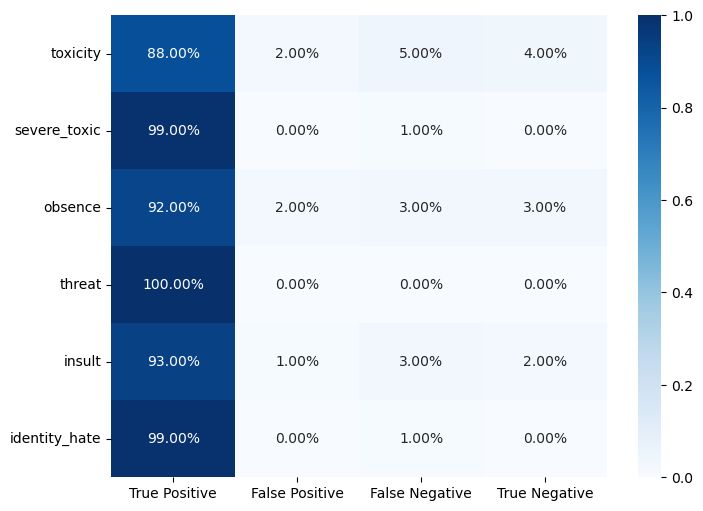

In [121]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix


# 生成随机的混淆矩阵
mcm_GRU = multilabel_confusion_matrix(test_label_L, pre_GRU) # target在前，pred在后
print(mcm_LSTM)

# 将3维数组展开为2维数组
flat_matrix = np.reshape(mcm_GRU, (mcm_GRU.shape[0], -1))
conf_matrix_pct = np.around(flat_matrix / np.sum(flat_matrix, axis=1, keepdims=True) , decimals=2)


# 绘制热力图
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(conf_matrix_pct, annot=True, fmt = '.2%',cmap='Blues')


# 设置坐标轴标签
# ax.set_xticks([0.5, 1.5, 2, 2,5])
# 设置行标签
ax.set_yticklabels(['toxicity', 'severe_toxic', 'obsence', 'threat','insult', 'identity_hate'], rotation=0)

# 设置列标签
ax.set_xticklabels(['True Positive', 'False Positive', 'False Negative', 'True Negative'], fontsize=10)
# ax.set_xticklabels(['True Negative', 'True Positive','False Negative','False Positive'])
# ax.set_yticklabels(['toxicity', 'severe_toxic', 'threat', 'obsence', 'insult', 'identity_hate'])

# 显示图形
plt.show()


In [122]:
from sklearn.metrics import classification_report

class_names = ['toxicity', 'severe_toxic', 'obsence', 'threat','insult', 'identity_hate']


# 按照类别生成分类报告
for i in range(len(class_names)):
    target_names = ['non-' + class_names[i], class_names[i]]
    report = classification_report(test_label_L[:,i], pre_GRU[:,i])
    print(f'Classification Report for {class_names[i]}:\n{report}\n')



Classification Report for toxicity:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     57888
           1       0.63      0.43      0.51      6090

    accuracy                           0.92     63978
   macro avg       0.79      0.70      0.74     63978
weighted avg       0.91      0.92      0.92     63978


Classification Report for severe_toxic:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     63611
           1       0.48      0.08      0.13       367

    accuracy                           0.99     63978
   macro avg       0.74      0.54      0.56     63978
weighted avg       0.99      0.99      0.99     63978


Classification Report for obsence:
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     60287
           1       0.64      0.53      0.58      3691

    accuracy                           0.96     63978
   macro avg   

/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/legfot/opt/anaconda3/envs/tf27/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

In [133]:
a = int(30000 ** 0.25)
print(a)

13
